# Simulated Data Preparation for ProteoForge with Imputation


In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulatio

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 


sys.path.append('../')
from src import utils, sims, plots#, tests

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

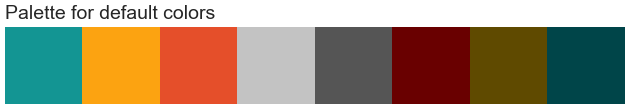

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

In [ ]:
notebook_name = "01_BuildLogic"
# data_path = "./data/input/"
output_path = f"./data/generated/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Establish the base Data

### Define Base Data Parameters

In [4]:
# Parameters
seed=42               # Seed for reproducibility
np.random.seed(seed)  # Set the seed
n_condition = 3       # Number of conditions (1 is control, others cond-N-1)
n_proteins = 400      # Number of proteins in the dataset
n_replicates = 5     # Number of replicates per condition
n_peptides = (5, 30)  # (min, max) for peptides per protein

# Define protein names
protein_names = [f"Protein_{i+1}" for i in range(n_proteins)]
print(f"Protein names: {protein_names[:3]}...{protein_names[-3:]}")


Protein names: ['Protein_1', 'Protein_2', 'Protein_3']...['Protein_398', 'Protein_399', 'Protein_400']


## Generate Protein Intensities

### Control Sample Protein Mean

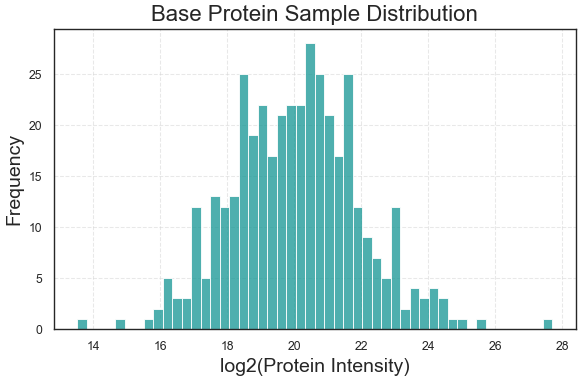

In [5]:
mean_values = sims.normal_distribution_with_outliers(
    mu = 20,  
    sd = 2,  
    size = n_proteins, 
    is_log2=False, 
    outlier_fraction=0.10, 
    outlier_sd_multiplier=1.0, 
    seed=42
)
mean_values = 2**mean_values

ax = sns.histplot(np.log2(mean_values), bins=50)
ax.set_xlabel("log2(Protein Intensity)", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.set_title("Base Protein Sample Distribution", fontsize=16)
plt.tight_layout()

### Control Sample Replicate CVs

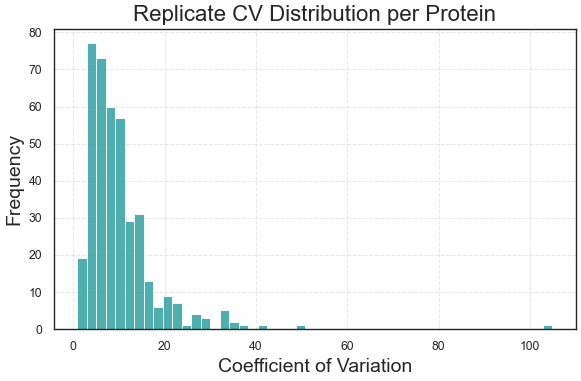

In [6]:
cv_values = sims.lognormal_distribution(
    mu=10,
    med=8,
    size=n_proteins,
    seed=42
)

ax = sns.histplot(cv_values, bins=50)
ax.set_xlabel("Coefficient of Variation", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.set_title("Replicate CV Distribution per Protein", fontsize=16)
plt.tight_layout()

### Simulate Control Sample with Replicates

In [7]:
control_data = sims.generate_replicates(
    mean_values, 
    cv_values,
    meanScale="raw",
    cvType="percent", 
    nReps=n_replicates, 
    randomizeCV=True,
    as_dataframe=True, 
    seed=42
)

control_data.head()

,0,1,2,3,4
0,87018.5336,270919.8875,133146.5305,216895.5121,99014.1840
1,1300436.7210,1445260.1318,1175023.1726,1240771.8842,1200914.8276
2,563298.1471,520009.3127,513916.5913,517056.7713,526163.3398
3,4727812.5856,4968340.8147,5282785.3342,5117263.6187,5715599.4122
4,1043232.4122,1050946.2248,1083538.9418,1229932.6417,1012335.0254


### Visualize the Mean and CVs of the Control Sample

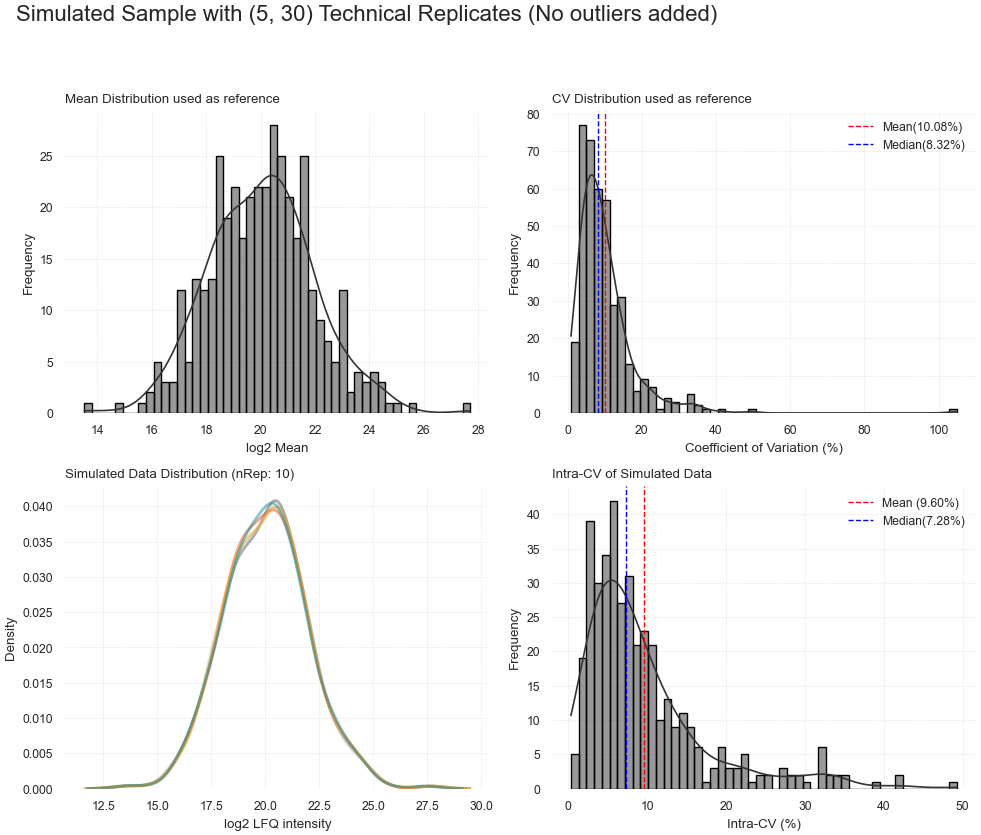

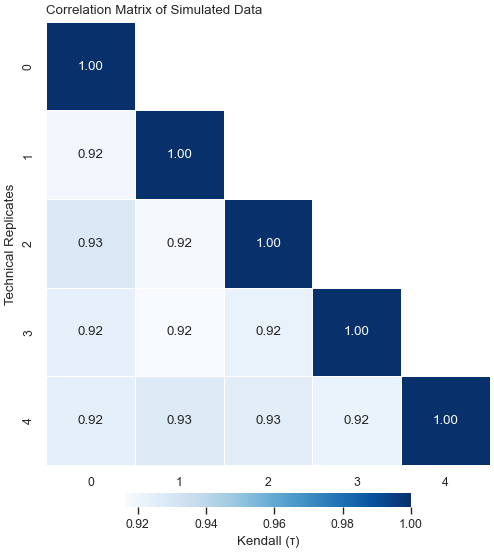

In [8]:
# Initialize the figure 1x3
fig, ax = plt.subplots(
    figsize=(10, 8),
    ncols=2,
    nrows=2,
    # sharex=True,
)
# Histogram of Mean values introduced for the simulation
sns.histplot(
    ax=ax[0, 0],
    data=np.log2(mean_values),
    bins=50,
    color="#333533",
    kde=True,
    linewidth=1,
    edgecolor="black",
)

# Histogram of CV values introduced for the simulation
sns.histplot(
    ax=ax[0, 1],
    data=cv_values,
    bins=50,
    color="#333533",
    kde=True,
    linewidth=1,
    edgecolor="black",
)

# Density plot of the simulated data
sns.kdeplot(
    ax=ax[1, 0],
    data=np.log2(control_data),
    linewidth=2,
    alpha=0.5,
    fill=False,
    label=None,
    legend=False,
)

# Intra-sample CV of the simulated data
intra_cv_simulated = control_data.std(axis=1) / control_data.mean(axis=1) * 100
sns.histplot(
    ax=ax[1, 1],
    data=intra_cv_simulated,
    bins=50,
    color="#333533",
    kde=True,
    linewidth=1,
    edgecolor="black",
)

# Set the axis labels
ax[0, 0].set_xlabel("log2 Mean")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].set_title("Mean Distribution used as reference", loc="left")

# ax[0, 1].set_xlabel("Coefficient of Variation (%)")
# ax[0, 1].set_ylabel("Frequency")
# ax[0, 1].set_title("CV Distribution", loc="left")

ax[0, 1].set_xlabel("Coefficient of Variation (%)")
ax[0, 1].set_ylabel("Frequency")
ax[0, 1].set_title("CV Distribution used as reference", loc="left")

ax[1, 0].set_xlabel("log2 LFQ intensity")
ax[1, 0].set_ylabel("Density")
ax[1, 0].set_title(f"Simulated Data Distribution (nRep: {10})", loc="left")

ax[1, 1].set_xlabel("Intra-CV (%)")
ax[1, 1].set_ylabel("Frequency")
ax[1, 1].set_title("Intra-CV of Simulated Data", loc="left")

# Add mean and median CVs to both CV plots
ax[0, 1].axvline(
    x=np.mean(cv_values),
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Mean({np.mean(cv_values):.2f}%)",
)
ax[0, 1].axvline(
    x=np.median(cv_values),
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Median({np.median(cv_values):.2f}%)",
)

# Add mean and median CVs to both CV plots
ax[1, 1].axvline(
    x=intra_cv_simulated.mean(),
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Mean ({intra_cv_simulated.mean():.2f}%)",
)
ax[1, 1].axvline(
    x=intra_cv_simulated.median(),
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Median({intra_cv_simulated.median():.2f}%)",
)

# Add legend
ax[0, 1].legend(frameon=False, loc="upper right")
ax[1, 1].legend(frameon=False, loc="upper right")

# Add grid
for a in ax.flatten():
    a.grid(axis="both", which="major", color="lightgrey", linestyle="--", linewidth=.5, alpha=0.5, zorder=1)

fig.suptitle(
    f"Simulated Sample with {n_peptides} Technical Replicates (No outliers added)", 
    fontsize=16, y=1.05, x=0.025, ha="left"
)

sns.despine(left=True, bottom=True)
plt.tight_layout()

# Heatmap of correlation matrix
corr_matrix = control_data.corr(method="kendall")
# mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 6))
# Create a heatmap
sns.heatmap(
    ax=ax,
    data=corr_matrix,
    cmap="Blues",
    mask=mask,
    annot=True,
    fmt=".2f",
    # vmin=0,
    # vmax=1,
    linewidths=0.5,
    cbar_kws={
        # "label": "Spearman (ρ)",
        "label": "Kendall (τ)",
        "orientation": "horizontal",
        "shrink": 0.5,
        "pad": 0.05,
    },
    square=True,
)

# Set the axis labels
ax.set_xlabel("")
ax.set_ylabel("Technical Replicates")
ax.set_title("Correlation Matrix of Simulated Data", loc="left")
# ax.grid(axis="both", which="major", color="lightgrey", linestyle="--", linewidth=.5, alpha=0.5, zorder=1)
# sns.despine(left=True, bottom=True)
plt.tight_layout()

## Generate Peptides and Their Intensities per Protein

### Peptide per Protein

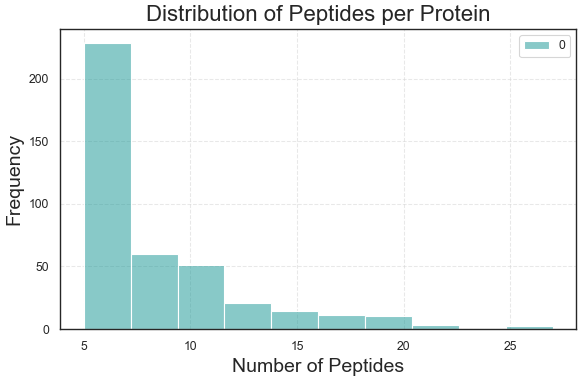

In [11]:
## Generate peptide per proteins and map them

# Define the range for the number of peptides
min_peptides, max_peptides = n_peptides[0], n_peptides[1]

# Generate the number of peptides per protein
pepN_cnts = sims.generate_peptide_counts(
    n_proteins=n_proteins,
    min_peptides=min_peptides,
    max_peptides=max_peptides,
    alpha=.5, 
    beta=3,
)

# Plot the distribution of peptides per protein
ax = sns.histplot(pepN_cnts.values(), bins=10)
ax.set_xlabel("Number of Peptides", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.set_title("Distribution of Peptides per Protein", fontsize=16)
plt.tight_layout()

### Draw Normal Distribution for Peptides per Protein

Using the Protein Intensity which will be the mean of the normal distribution, I will generate the peptide intensities for each protein. The number of peptides are already generated and the ids are stored in `pep_mapping` dictionary. The standard deviation and the outlier introduction is controlled by variables that is passed to the function.

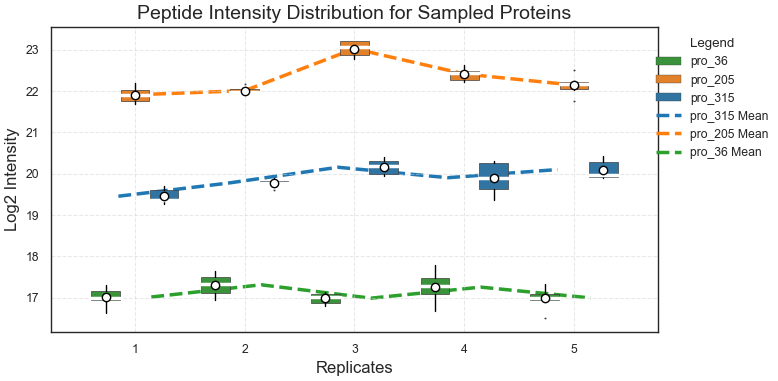

In [12]:
# Draw Normal Distribution for the number of peptides

pep_data = sims.generate_peptide_level(
    control_data,
    pepN_cnts,
    is_log2=False,         
    repStd=(0.1, 0.25),
    outlier_fraction=0.0001,
    outlier_multiplier=0.01,
    add_noise=True,
    noise_sd=0.10,
    seed=42
)

# Display the resulting DataFrame
plot_data = pep_data.melt(
    id_vars=["Protein", "Peptide"],
    var_name="Replicate",
    value_name="Intensity"
)
plot_data['Intensity'] = np.log2(plot_data['Intensity'])
plot_data['Replicate'] = plot_data['Replicate'].str.split("_").str[-1].astype(int)
cur_protein = pd.Series(plot_data["Protein"].unique()).sample(3).tolist()
cur_data = plot_data[plot_data["Protein"].isin(cur_protein)]
# Create pal: a dictionary of colors for each protein
pal = dict(zip(cur_protein, sns.color_palette("tab10", n_colors=len(cur_protein))))

fig, ax = plt.subplots(figsize=(8, 4))
# Create a boxplot
sns.boxplot(
    ax=ax,
    data=cur_data,
    x="Replicate",
    y="Intensity",
    hue="Protein",
    palette=pal,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)
# Draw mean lines for each protein across replicates
for i, protein in enumerate(cur_protein):
    # Get the mean values for the current protein
    mean_values = cur_data[cur_data["Protein"] == protein].groupby("Replicate")["Intensity"].mean()
    offset = 0.15 * (i - 1)
    # Draw the mean lines
    ax.plot(
        mean_values.index - 1.0 + offset,
        mean_values,
        color=pal[protein],
        linestyle="--",
        linewidth=2.5,
        label=f"{protein} Mean",
        zorder=0,
    )

# Set the axis labels
ax.set_xlabel("Replicates", fontsize=12)
ax.set_ylabel("Log2 Intensity", fontsize=12)
ax.set_title(f"Peptide Intensity Distribution for Sampled Proteins", fontsize=14)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(title="Legend", loc="upper right", bbox_to_anchor=(1.2, 1), frameon=False)
plt.tight_layout()

## Create other Conditions and Samples

### Generate Conditions

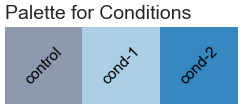

Condition Shifts: {'control': 0, 'cond-1': 1, 'cond-2': 2}
Condition Palette: {'control': '#8d99ae', 'cond-1': '#abd0e6', 'cond-2': '#3787c0'}

Sample Palette: {'control-1': '#8d99ae', 'control-2': '#8d99ae', 'control-3': '#8d99ae', 'control-4': '#8d99ae', 'control-5': '#8d99ae', 'cond-1-1': '#abd0e6', 'cond-1-2': '#abd0e6', 'cond-1-3': '#abd0e6', 'cond-1-4': '#abd0e6', 'cond-1-5': '#abd0e6', 'cond-2-1': '#3787c0', 'cond-2-2': '#3787c0', 'cond-2-3': '#3787c0', 'cond-2-4': '#3787c0', 'cond-2-5': '#3787c0'}
Condition Sample Map: {'control': ['control-1', 'control-2', 'control-3', 'control-4', 'control-5'], 'cond-1': ['cond-1-1', 'cond-1-2', 'cond-1-3', 'cond-1-4', 'cond-1-5'], 'cond-2': ['cond-2-1', 'cond-2-2', 'cond-2-3', 'cond-2-4', 'cond-2-5']}


In [19]:
from importlib import reload
reload(sims)

# Example usage
condition_sample_map, condition_palette, sample_palette, condition_shifts = sims.generate_condition_mappers(
    n_condition=2,
    n_replicates=n_replicates,
    condition_shifts=[1, +2],
    control_name="control",
    control_color="#8d99ae",
    condition_suffix="cond-",
    condition_palette="Blues",

)

plots.color_palette(
    condition_palette,
    name="Conditions",
    save=False
)
print(f"Condition Shifts: {condition_shifts}")
print(f"Condition Palette: {condition_palette}")
print()
print(f"Sample Palette: {sample_palette}")
print(f"Condition Sample Map: {condition_sample_map}")


### Build The Data

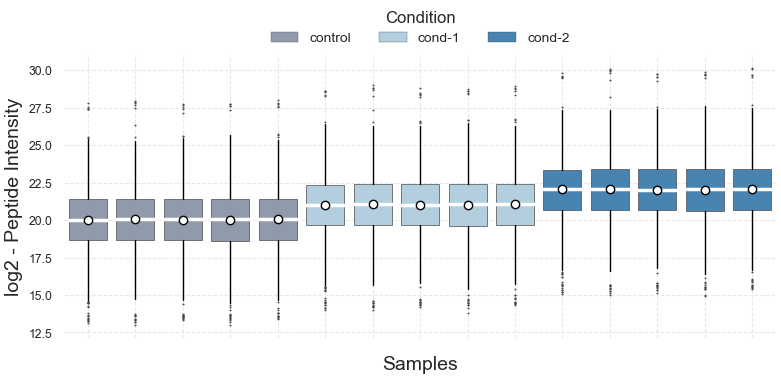

In [20]:
from importlib import reload
reload(sims)

# Copy the peptide data to create the condition data
complete_data = sims.generate_complete_data(
    pep_data,
    condition_shifts=condition_shifts,
    condition_sample_map=condition_sample_map,
    shift_scale=0.10,
    is_log2=False,
    add_noise=False,
    seed=42
)

# Save the data to a feather file
complete_data.to_feather(f"{output_path}complete_data.feather")
    
plot_data = np.log2(complete_data).reset_index().melt(
    id_vars=["Protein", "Peptide"],
    var_name="Sample",
    value_name="Intensity"
)

plot_data['Condition'] = plot_data['Sample'].apply(lambda x: "-".join(x.split("-")[:-1]))

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="Sample",
    y="Intensity",
    hue="Condition",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=condition_palette,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)
# Set the x-axis labels
ax.set_xlabel("Samples", fontsize=14)
ax.set_ylabel("log2 - Peptide Intensity", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(
    ncol=4, frameon=False, title="Condition", 
    title_fontsize=12, fontsize=10, 
    # Center the legend on top
    bbox_to_anchor=(0.5, 1.1), loc="center"
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

## Visualize the Data with Raw - Centered - Adjusted Intensities

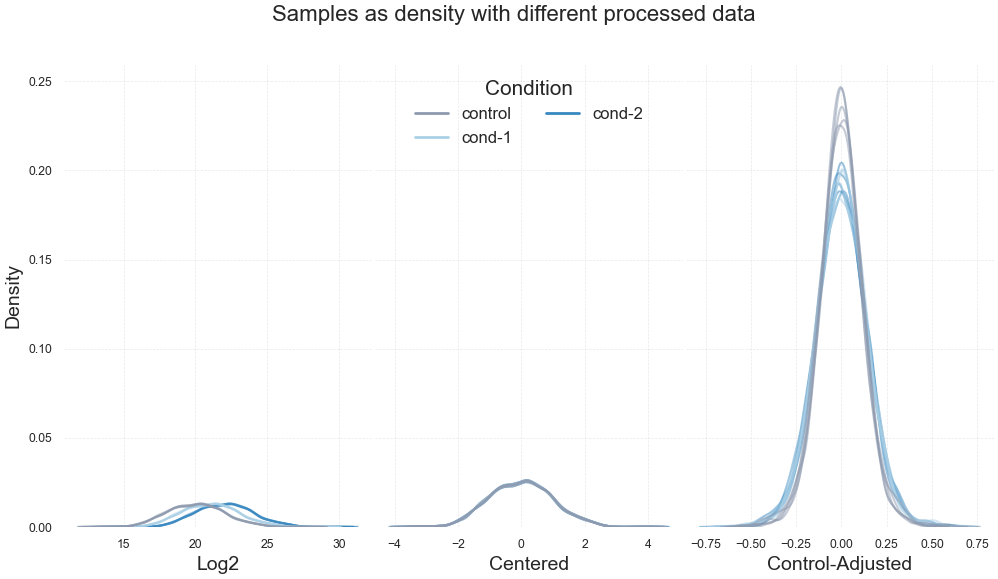

In [21]:
# Set to log2 scale (if needed)
log2_data = np.log2(complete_data)
# Center and scale the data
centered_data = (log2_data - log2_data.mean()) / log2_data.std()
# Adjusted data
# Calculate the mean of each peptide across the day1 samples
cntrPepMean = centered_data[condition_sample_map["control"]].mean(axis=1)
# Substract cntrPepMean from each sample row-wise in centered_data
adjusted_dat = centered_data.subtract(cntrPepMean, axis=0)

# Visualize the log2, centered and adjusted data densities with 3 subplots 1x3
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True,gridspec_kw={"wspace": 0.01})
for i, cur_data, cur_title in zip(
    range(3), 
    [log2_data, centered_data, adjusted_dat], 
    ["Log2", "Centered", "Control-Adjusted"]
):
    sns.kdeplot(
        data=cur_data,
        ax=axs[i],
        palette=sample_palette,
        linewidth=1.5,
        alpha=0.5,
        legend=False,
    )

    # axs[i].set_title(cur_title)
    axs[i].set_xlabel(cur_title, fontsize=14)
    axs[i].set_ylabel("Density", fontsize=14)
    axs[i].grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")    
    # Create legend for middle plot
    if i == 1:
        handles = []
        labels = []
        for k, v in condition_palette.items():
            handles.append(plt.Line2D([0], [0], color=v, lw=2))
            labels.append(k)

        axs[i].legend(
            handles,
            labels,
            title="Condition",
            title_fontsize=15,
            fontsize=12,
            frameon=False,
            loc="upper center",
            ncol=2, 
        )

fig.suptitle("Samples as density with different processed data", fontsize=16)
sns.despine(fig, top=True, right=True, left=True, bottom=True)
plt.tight_layout()